# Set up environment and useful functions

In [99]:
# setup  the environment
import networkx as nx
import yaml
import random
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [100]:
# draw flows and capacities
def draw_all(G, save_fig=False, path = "plots/graph_all.png"):
    """
    Draw the graph G with flow and capacity attributes.

    Parameters:
    - G: NetworkX graph object
        The graph to be drawn.
    - save_fig: bool, optional (default=True)
        Whether to save the figure as an image file.
    """
    # create labels
    edge_labels = list(G.edges(data=True))
    format = lambda e : f"{e['name']} = {e['flow']}/{e['capacity']}"
    edge_labels = {(x, y): format(data) for x, y, data in edge_labels}

    # set up color_mapping and pos
    color_mapping = nx.get_node_attributes(G, 'color').values()
    layout = nx.get_node_attributes(G, 'pos')
    
    # draw graph with edge labels
    nx.draw(G, layout, node_color=color_mapping, with_labels=True)
    nx.draw_networkx_edge_labels(G, layout, edge_labels=edge_labels)
    plt.title(f"Graph with flow and capacity attributes")

    # save it
    if save_fig:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path)
    plt.show()

# functions which can be useful
def draw(G, attribute='name', save_fig=False, path = "plots/graph.png"):
    """
    Draw a graph with optional edge labels and save it as a PNG file.

    Parameters:
    - G (networkx.Graph): The graph to be drawn.
    - attribute (str): The attribute to be used as edge labels (default: 'name').
    - save_fig (bool): Whether to save the figure as a PNG file (default: True).
    """
    # set up color_mapping and pos
    color_mapping = nx.get_node_attributes(G, 'color').values()
    layout = nx.get_node_attributes(G, 'pos')

    # set up edge_labels
    edge_labels = nx.get_edge_attributes(G, attribute)

    # draw graph with edge labels
    nx.draw(G, layout, node_color=color_mapping, with_labels=True)
    nx.draw_networkx_edge_labels(G, layout, edge_labels=edge_labels)
    plt.title(f"Graph with {attribute} attribute")
    
    # save it
    if save_fig:
        path = os.path.splitext(path)[0] + f"_{attribute}.png"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path)
    plt.show()

def update_edge_flows(G, source='o', dest='d'):
    """
    Update the edge flows in a network graph.

    Parameters:
    - G (networkx.Graph): The network graph.
    - source (str): The source node.
    - dest (str): The destination node.

    Returns:
    - edge_flows (dict): A dictionary where keys are edges and values are flows.
    """
    # find maximum flow
    max_flow = nx.maximum_flow(G, source, dest)

    # convert maximum flow to dictionary, keys are edges, values are flows
    edge_flows = {
        (x, y): flow
        for x, dictionary in max_flow[1].items()
        for y, flow in dictionary.items()
    }
    
    #update attribute
    nx.set_edge_attributes(G, edge_flows, 'flow')

    # return them
    return edge_flows

def update_residual_capacities(G, source='o', dest='d'):
    """Update residual capacities of edges in G

    Args:
        G (nx.DiGraph): graph
        source (str, optional): source node. Defaults to 'o'.
        dest (str, optional): destination node. Defaults to 'd'.

    Returns:
        dict: dictionary of residual capacities of edges
    """
    # get edge attributes
    edge_flows = nx.get_edge_attributes(G, 'flow')
    edge_capacities = nx.get_edge_attributes(G, 'capacity')
    # compute residual capacities
    residual_capacities = {
        edge: edge_capacities[edge] - edge_flows[edge]
        for edge in G.edges
    }
    # update attribute
    nx.set_edge_attributes(G, residual_capacities, 'residual_capacity')
    return residual_capacities

def create_config(path = "resources/config.yaml"):
    """Create a config file with a graph and save it as a YAML file.

    Parameters:
    - path (str): The path to the config file (default: 'resources/config.yaml').

    Returns:
    - config (dict): The config dictionary, with two keys: 'edges' and 'nodes'.
        each key has a list of lists as value. with the following structure:
        - edges: [[source, destination, {attributes}], ...]
        - nodes: [[node, {attributes}], ...]
    """
    # create config
    config = {
        'edges': [
            ['o','a',{'name': 'e1', 'capacity': 3}],
            ['o','b',{'name': 'e3', 'capacity': 3}],
            ['a','d',{'name': 'e2', 'capacity': 2}],
            ['b','d',{'name': 'e4', 'capacity': 2}],
            ['b','c',{'name': 'e5', 'capacity': 3}],
            ['c','d',{'name': 'e6', 'capacity': 1}]
        ],
        'nodes': [
            ['o',{'pos': [0,0], 'color': 'red'}],
            ['d',{'pos': [1,0], 'color': 'green'}],
            ['a',{'pos': [0.5,0.5], 'color': 'blue'}],
            ['b',{'pos': [0.5,0], 'color': 'blue'}],
            ['c',{'pos': [0.5,-0.5], 'color': 'blue'}],
        ]
    }
    # write config to file
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as file:
        yaml.dump(config, file)


def read_config(path = "resources/config.yaml", create=True):
    """Read a config file with a graph and save it as a YAML file.

    Parameters:
    - path (str): The path to the config file (default: 'resources/config.yaml').
    - create (bool): Whether to create the config file if it does not exist (default: True).

    Returns:
    - config (dict): The config dictionary, with two keys: 'edges' and 'nodes'.
        each key has a list of lists as value. with the following structure:
        - edges: [[source, destination, {attributes}], ...]
        - nodes: [[node, {attributes}], ...]
    """
    # create config if it does not exist
    if not os.path.exists(path) and create:
        create_config(path)
    # read config from file
    with open(path, 'r') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

# Load the graph

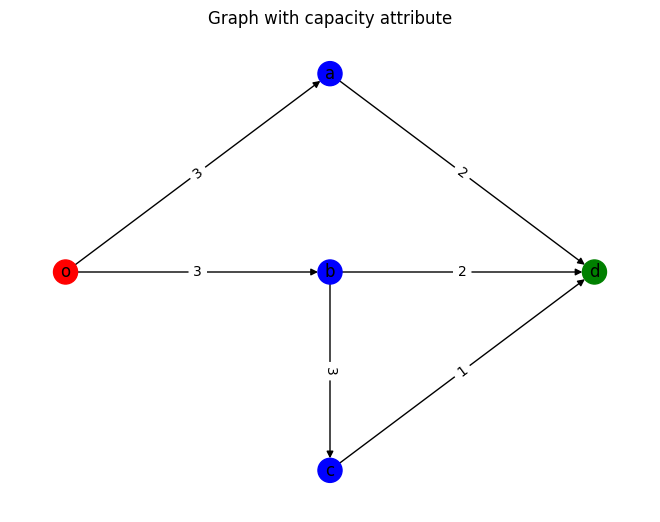

In [101]:
# config.yaml has already been created, in the cell above you can see how. (create_config())
# If you want to change the graph, you can do it in the config.yaml file.
# If you lack the config.yaml file, don't worry, the function read_config() will create it for you.
# You can set the attribute create to False, so that the function does not create the file if it does not exist.

# read config, and allocates edges and nodes
config = read_config()
edges, nodes = config.values()

# create the graph
G = nx.DiGraph(edges)
G.add_nodes_from(nodes)

# draw graph
draw(G, attribute='capacity')

# Question 1

In [102]:
question1 = """Point a:
What is the minimum aggregate capacity that needs to be removed for no 
feasible flow from o to d to exist?
"""
answer = """Answer:
The maximum flow is corresponding to the minimum aggregate capacity
we need to subtract to isolate o and d.

In our case"""
# find and print maximum flow
max_flow = nx.maximum_flow_value(G, 'o', 'd')

print(question1)
print(f"{answer}, {max_flow}.")

Point a:
What is the minimum aggregate capacity that needs to be removed for no 
feasible flow from o to d to exist?

Answer:
The maximum flow is corresponding to the minimum aggregate capacity
we need to subtract to isolate o and d.

In our case, 5.


# Question 2

Point b:
What is the maximum aggregate capacity that can be removed from
the edges without affecting the maximum throughput from o to d?

Answer:
The maximum aggregate capacity that can be removed from the links
can be obtained by subtracting the maximum flow of each edge from 
its capacity, and summing up the result.

In our case 3.


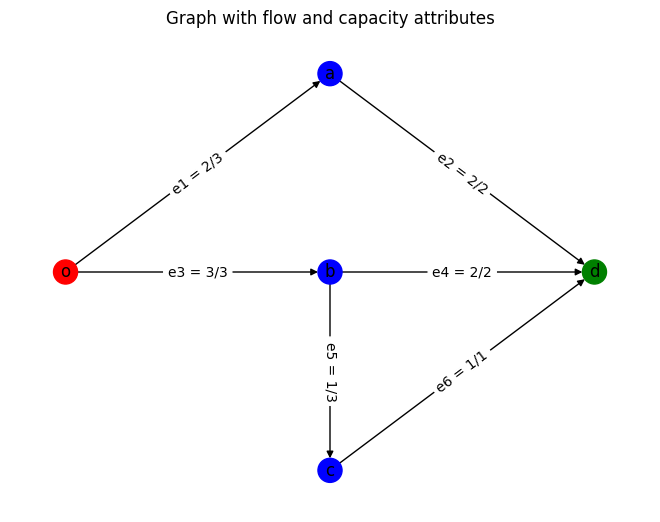

In [103]:
question2 = """Point b:
What is the maximum aggregate capacity that can be removed from
the edges without affecting the maximum throughput from o to d?
"""

answer="""Answer:
The maximum aggregate capacity that can be removed from the links
can be obtained by subtracting the maximum flow of each edge from 
its capacity, and summing up the result.

In our case"""

# update max flows
update_edge_flows(G)

# find residual capacity, the unused one, for each edge
residuals = update_residual_capacities(G)

# print answer
print(question2)
print(f"{answer} {sum(residuals.values())}.")

# draw the graph with edge labels
draw_all(G)

# Question 3

In [104]:
question3 = """Point c:
You are given x > 0 extra units of capacity. How should you distribute them
in order to maximize the throughput that can be sent from o to d? Plot the 
maximum throughput from o to d as a function of x ≥0.
"""
answer = """Answer:
I would work this way:
1.  Find the minimum cut partition.
3.  Add one unit of capacity of one of the edges in the cut, chosen at random.
4.  Repeat until all the capacity has been added."""

print(question3)
print(answer)

Point c:
You are given x > 0 extra units of capacity. How should you distribute them
in order to maximize the throughput that can be sent from o to d? Plot the 
maximum throughput from o to d as a function of x ≥0.

Answer:
I would work this way:
1.  Find the minimum cut partition.
3.  Add one unit of capacity of one of the edges in the cut, chosen at random.
4.  Repeat until all the capacity has been added.


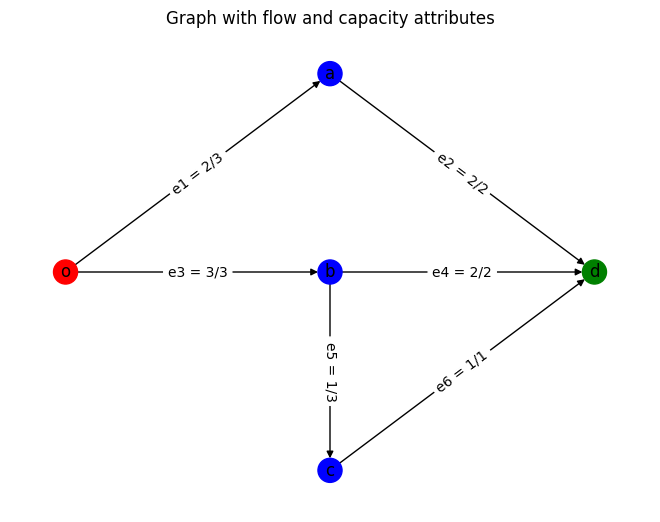

Capacity to be added: 5
Minimum cut value: 5
Minimum cut partition: {'c', 'a', 'b', 'o'}, {'d'}
Capacity of edge ('c', 'd') increased.

Capacity to be added: 4
Minimum cut value: 5
Minimum cut partition: {'a', 'o'}, {'c', 'd', 'b'}
Capacity of edge ('o', 'b') increased.

Capacity to be added: 3
Minimum cut value: 6
Minimum cut partition: {'c', 'a', 'b', 'o'}, {'d'}
Capacity of edge ('c', 'd') increased.

Capacity to be added: 2
Minimum cut value: 6
Minimum cut partition: {'a', 'o'}, {'c', 'd', 'b'}
Capacity of edge ('a', 'd') increased.

Capacity to be added: 1
Minimum cut value: 7
Minimum cut partition: {'a', 'o'}, {'c', 'd', 'b'}
Capacity of edge ('o', 'b') increased.

Capacity to be added: 0
Minimum cut value: 8
Minimum cut partition: {'c', 'a', 'b', 'o'}, {'d'}


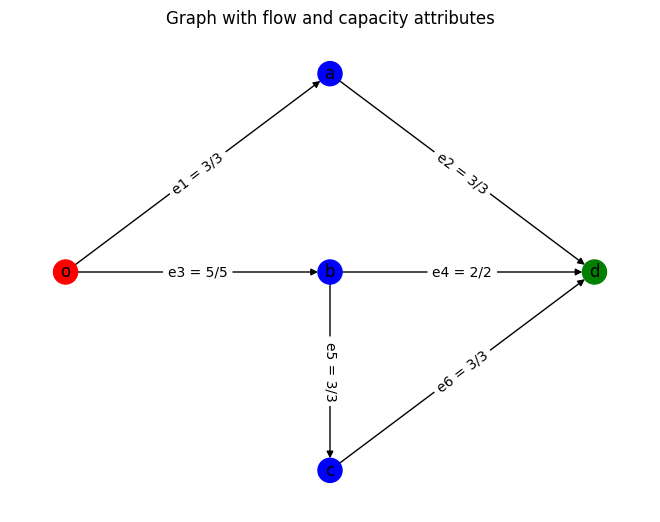

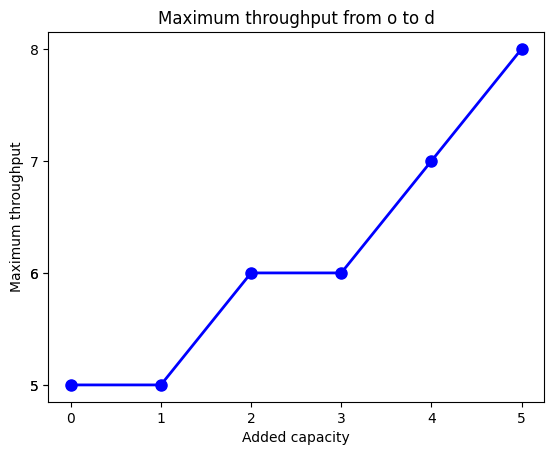

In [133]:
# Capacity to be added
capacity = 5
verbose = False
y = []
x = list(range(0, capacity+1))

# copy of G, in order to not modify the original graph
G_new = G.copy()
G_old = G.copy()

# draw the initial graph
draw_all(G_new)

# loop until all the capacity has been added
while True:
    # find minimum cut partition and print info
    max_flow, partition = nx.minimum_cut(G_old, 'o', 'd')
    y.append(max_flow)
    reachable, non_reachable = partition
    print(f"Capacity to be added: {capacity}")
    print(f"Minimum cut value: {max_flow}")
    print(f"Minimum cut partition: {reachable}, {non_reachable}")

    # Update attributes of G_new.
    update_edge_flows(G_new)
    update_residual_capacities(G_new)
    
    # Print info of edges.
    edge_flows = nx.get_edge_attributes(G_new, 'flow')
    edge_capacities = nx.get_edge_attributes(G_new, 'capacity')
    edge_names = nx.get_edge_attributes(G_new, 'name')
    if verbose:
        for edge in G_new.edges:
            print(f"Edge {edge} = {edge_flows[edge]} / {edge_capacities[edge]}")

    # Break if capacity is finished, after updating and printing.
    if capacity <= 0:
        break

    # Find edges which start in first and end in second partition.
    edges_to_increase = [
        edge
        for edge in G_old.edges
        if edge[0] in reachable and edge[1] in non_reachable
    ]

    # Increase capacity of edge in the cut, randomly chosen.
    edge = edges_to_increase[random.randint(0, len(edges_to_increase)-1)]
    G_new[edge[0]][edge[1]]['capacity'] += 1

    # Print the edge which increased the cut value.
    print(f"Capacity of edge {edge} increased.\n")  
    
    # Update capacity to be added.
    capacity -= 1

    # Update graph.
    G_old = G_new.copy()

# draw the final graph
draw_all(G_new)

# plot the maximum throughput from o to d as a function of x ≥0, as a fancy plot
plt.plot(x, y, marker='o', color='blue', linestyle='solid', linewidth=2, markersize=8)
plt.xlabel("Added capacity")
plt.ylabel("Maximum throughput")
plt.title("Maximum throughput from o to d")
# show all the x values
plt.xticks(x)
plt.yticks(y)
plt.show()
